## Installation

#### Mac Specific Caveats

In [10]:
import sys

sys.path.append("/Users/broxoli/models")

#### General Installation

In [11]:
%%capture
import operator

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import importlib as imp

from collections import namedtuple
from random import sample, shuffle
from functools import reduce
from itertools import accumulate
from math import floor, ceil, sqrt, log, pi
from matplotlib import pyplot as plt
from tensorflow.keras import layers, utils, losses, models as mds, optimizers, applications as apps

if imp.util.find_spec('aggdraw'): import aggdraw
if imp.util.find_spec('tensorflow_addons'): from tensorflow_addons import layers as tfa_layers
# if imp.util.find_spec('tensorflow_models'): from official.nlp.modeling.models import T5Transformer, T5TransformerParams
if imp.util.find_spec('tensorflow_models'): from official.nlp.modeling import models as tfm_models, layers as tfm_layers
if imp.util.find_spec('tensorflow_probability'): from tensorflow_probability import distributions as tfd
if imp.util.find_spec('keras_tuner'): import keras_tuner as kt

## Datasets

In [59]:
# %%capture
(raw_train_ds, raw_val_ds, raw_test_ds), ds_info = tfds.load(
    'voc',
    with_info=True,
    split=['train', 'validation', 'test'],
    as_supervised=False,
    read_config=tfds.ReadConfig(try_autocache=False)
)

# tf.print(ds_info.features['objects']['bbox'].encode_example({'xmax': .1, 'ymax': .2, 'xmin': .5, 'ymin': .2}))
# tf.print(ds_info.features['objects']['bbox'].encode_example([.2]))

# train_ds = train_ds.map(lambda item: (item['image'], item['labels']))
ds_info

# itr = iter(train_ds)
# plt.imshow(next(itr)[0])

tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_path='/Users/broxoli/tensorflow_datasets/voc/2007/4.0.0',
    download_size=868.85 MiB,
    d

In [83]:
IMG_SIZE = 224
N_CLASSES = ds_info.features['labels'].num_classes

BOX_DIMS = 4
MAX_BOX_QUERIES = 20

def dsitem_to_tuple(item):
    image = item['image']
    boxes = item['objects']['bbox']
    labels = item['objects']['label']
    
    float_labels = tf.cast(labels[:, None], dtype=tf.float32)
    box_attrs = tf.concat([float_labels, boxes], axis=-1)
    
    return image, box_attrs

def resize(image, boxes):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], method='bilinear') # For downsizing
    image = tf.cast(image, tf.uint8)
    
    return (image, boxes)

train_ds = raw_train_ds.map(dsitem_to_tuple)
train_ds = train_ds.map(resize).shuffle(2000, reshuffle_each_iteration=True)

# itr = iter(train_ds)
# next(itr)[1]

[(0, 'aeroplane'), (1, 'bicycle'), (2, 'bird'), (3, 'boat'), (4, 'bottle'), (5, 'bus'), (6, 'car'), (7, 'cat'), (8, 'chair'), (9, 'cow'), (10, 'diningtable'), (11, 'dog'), (12, 'horse'), (13, 'motorbike'), (14, 'person'), (15, 'pottedplant'), (16, 'sheep'), (17, 'sofa'), (18, 'train'), (19, 'tvmonitor')]


(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([12, 14, 12, 14])>,
 TensorShape([480, 389, 3]),
 <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[0.14375   , 0.0437018 , 0.97083336, 0.7763496 ],
        [0.14583333, 0.24164525, 0.57916665, 0.6066838 ],
        [0.6       , 0.5244216 , 0.8541667 , 0.76606685],
        [0.56041664, 0.5012854 , 0.7395833 , 0.6863753 ]], dtype=float32)>)

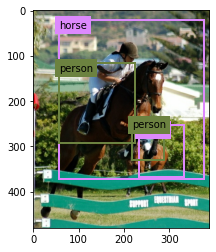

In [81]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def bbox_to_rect(bbox, shape, color):
    """Convert bounding box to matplotlib format."""
    h, w = shape
    left, top, right, bottom = bbox[0]*w, bbox[1]*h, bbox[2]*w, bbox[3]*h
    
    rect = plt.Rectangle(
        xy=(left, top), width=right-left, height=bottom-top,
        fill=False, edgecolor=color, linewidth=2)

    return rect

LABELS = ds_info.features['labels'].names
CLASS_COLORS = list(map(lambda v: rgb_to_hex(tuple(v.tolist())), np.random.choice(range(64, 255),size=[N_CLASSES, 3])))

# itr = iter(train_ds)
itr = iter(raw_train_ds)
item = next(itr)

fig = plt.imshow(item['image'])

def draw_boxes(image, fig):
    box_shape = image.shape[:2]
    objs = item['objects']
    
    for index, bbox in enumerate(objs['bbox']):
        rect = bbox_to_rect(bbox, box_shape, CLASS_COLORS[objs['label'][index]])
        fig.axes.add_patch(rect)
        fig.axes.text(*rect.get_xy(), LABELS[objs['label'][index]], ha='left', va='top', bbox=dict(ec='none', fc=CLASS_COLORS[objs['label'][index]]))

draw_boxes(item['image'], fig)
print(list(enumerate(ds_info.features['labels'].names)))
item['objects']['label'], item['image'].shape, item['objects']['bbox']

In [111]:
def calibrate_null_class(boxes):
    sparse_classes, boxes = tf.split(boxes, [1, BOX_DIMS], axis=-1)
    sparse_classes += 1

    boxes = tf.concat([sparse_classes, boxes], axis=-1)
    return boxes

def dense_boxes(boxes):
    n_boxes = tf.shape(boxes)[0]
    empties = tf.zeros((MAX_BOX_QUERIES-n_boxes, BOX_DIMS+1), dtype=tf.float32)
    boxes = tf.concat([boxes, empties], axis=0)

    return boxes

dtrain_ds = train_ds.map(lambda x,y: (x, calibrate_null_class(y)))
dtrain_ds = dtrain_ds.map(lambda x,y: (x, dense_boxes(y)))
itr = iter(dtrain_ds)
y_true = next(itr)[1]
tf.print(y_true)

[[5 0.597597599 0.768 0.807807803 0.83]
 [15 0.207207203 0.896 0.717717707 1]
 [15 0.183183178 0.47 1 0.874]
 ...
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [68]:
# backbone = hub.KerasLayer('https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4')

def get_loss_fn(y_true, y_pred):
    t_sparse_classes, t_boxes = tf.split(y_true, [1, BOX_DIMS], axis=-1)
    p_classes, p_boxes = tf.split(y_pred, [N_CLASSES+1, BOX_DIMS], axis=-1)

    def bipartite():
        pass

    def hungarian():
        # Classification cost for the Hungarian algorithom 
        # On each prediction. We select the prob of the expected class
        cost_class = tf.gather(p_classes, t_sparse_classes, axis=1)

        pass

    tf.print(t_sparse_classes, t_boxes, p_classes, p_boxes)

    return 1.0

def create_model(hidden_dims=256, num_attention_heads=8, encoder_layers=6, decoder_layers=6):
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    query_shape = (MAX_BOX_QUERIES, hidden_dims)

    # Image Inputs
    inp = tf.keras.Input(shape=input_shape)

    # Feature Extraction Layers
    backbone = apps.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    transormation_layer = tf.keras.Sequential([
        layers.Conv2D(hidden_dims, 1, padding='same'),
        layers.Reshape((-1, hidden_dims))
    ])

    # Input and Output Position Encodings
    # position_encoding = tfm_layers.RelativePositionEmbedding(hidden_dims)
    # output_pos_encoding = tfm.layers.RelativePositionEmbedding(hidden_dims)
    query_embds = tf.Variable(tf.compat.v1.keras.initializers.glorot_uniform()(query_shape))

    # Encoder and Decoder Layers
    encoder = tfm_models.TransformerEncoder(encoder_layers, num_attention_heads, hidden_dims)
    decoder = tfm_models.TransformerDecoder(decoder_layers, num_attention_heads, hidden_dims)

    # Detection Layers
    layer_classes = layers.Dense(N_CLASSES+1, activation='softmax')
    layer_bboxes = tf.keras.Sequential([
        layers.Dense(hidden_dims, activation='relu'),
        layers.Dense(hidden_dims, activation='relu'),
        layers.Dense(BOX_DIMS, activation='sigmoid')
    ])

    x = backbone(inp)

    # Create a zero mask for the image input with shape: (BATCH, H*W)
    batch_size, H, W, _ = tf.shape(x)
    # masks = tf.zeros((batch_size, H*W, -1), tf.bool)

    # Project the image features to the hidden dimension
    # The projection is unrolled into a sequence
    x = transormation_layer(x)

    # The output of the encoder is used as a memory to the decoder.
    # The decoder also receives a target sequence.
    memory = encoder(x)
    target = tf.tile(tf.expand_dims(query_embds, axis=0), [batch_size, 1, 1])
    x = decoder(target, memory)

    # The output of the decoder is used to predict the class and the bounding boxes
    x_classes = layer_classes(x)
    x_bboxes = layer_bboxes(x)

    # Combine the class and bounding box predictions
    output = tf.concat([x_classes, x_bboxes], axis=-1)

    model = tf.keras.Model(inp, output)

    optimizer = 'adam'
    loss = get_loss_fn
    metrics = None
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

model = create_model()
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_49[0][0]']               
                                                                                                  
 tf.compat.v1.shape_17 (TFOpLam  (4,)                0           ['resnet50[0][0]']               
 bda)                                                                                             
                                                                                           

In [78]:
t = tf.random.uniform((2, 3, 5))
classes = tf.gather(t, [0], axis=-2)
tf.print(t, classes)

[[[0.827783823 0.504994273 0.489998341 0.211164713 0.851602197]
  [0.0789039135 0.256217957 0.936600924 0.118571401 0.543498635]
  [0.24699378 0.1180861 0.0957052708 0.841326714 0.512848496]]

 [[0.332034707 0.397093892 0.2957654 0.655693769 0.755385041]
  [0.894960046 0.187517524 0.87929 0.347614765 0.222117186]
  [0.057014823 0.877532601 0.339468241 0.724159837 0.795142293]]] [[[0.827783823 0.504994273 0.489998341 0.211164713 0.851602197]]

 [[0.332034707 0.397093892 0.2957654 0.655693769 0.755385041]]]


In [69]:
tds = train_ds.batch(2).take(1)
model.fit(tds)

ValueError: in user code:

    File "/Users/broxoli/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/broxoli/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/broxoli/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/broxoli/miniforge3/lib/python3.9/site-packages/keras/engine/training.py", line 863, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/broxoli/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py", line 532, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "/Users/broxoli/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py", line 633, in apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    File "/Users/broxoli/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/utils.py", line 73, in filter_empty_gradients
        raise ValueError(f"No gradients provided for any variable: {variable}. "

    ValueError: No gradients provided for any variable: (['conv1_conv/kernel:0', 'conv1_conv/bias:0', 'conv1_bn/gamma:0', 'conv1_bn/beta:0', 'conv2_block1_1_conv/kernel:0', 'conv2_block1_1_conv/bias:0', 'conv2_block1_1_bn/gamma:0', 'conv2_block1_1_bn/beta:0', 'conv2_block1_2_conv/kernel:0', 'conv2_block1_2_conv/bias:0', 'conv2_block1_2_bn/gamma:0', 'conv2_block1_2_bn/beta:0', 'conv2_block1_0_conv/kernel:0', 'conv2_block1_0_conv/bias:0', 'conv2_block1_3_conv/kernel:0', 'conv2_block1_3_conv/bias:0', 'conv2_block1_0_bn/gamma:0', 'conv2_block1_0_bn/beta:0', 'conv2_block1_3_bn/gamma:0', 'conv2_block1_3_bn/beta:0', 'conv2_block2_1_conv/kernel:0', 'conv2_block2_1_conv/bias:0', 'conv2_block2_1_bn/gamma:0', 'conv2_block2_1_bn/beta:0', 'conv2_block2_2_conv/kernel:0', 'conv2_block2_2_conv/bias:0', 'conv2_block2_2_bn/gamma:0', 'conv2_block2_2_bn/beta:0', 'conv2_block2_3_conv/kernel:0', 'conv2_block2_3_conv/bias:0', 'conv2_block2_3_bn/gamma:0', 'conv2_block2_3_bn/beta:0', 'conv2_block3_1_conv/kernel:0', 'conv2_block3_1_conv/bias:0', 'conv2_block3_1_bn/gamma:0', 'conv2_block3_1_bn/beta:0', 'conv2_block3_2_conv/kernel:0', 'conv2_block3_2_conv/bias:0', 'conv2_block3_2_bn/gamma:0', 'conv2_block3_2_bn/beta:0', 'conv2_block3_3_conv/kernel:0', 'conv2_block3_3_conv/bias:0', 'conv2_block3_3_bn/gamma:0', 'conv2_block3_3_bn/beta:0', 'conv3_block1_1_conv/kernel:0', 'conv3_block1_1_conv/bias:0', 'conv3_block1_1_bn/gamma:0', 'conv3_block1_1_bn/beta:0', 'conv3_block1_2_conv/kernel:0', 'conv3_block1_2_conv/bias:0', 'conv3_block1_2_bn/gamma:0', 'conv3_block1_2_bn/beta:0', 'conv3_block1_0_conv/kernel:0', 'conv3_block1_0_conv/bias:0', 'conv3_block1_3_conv/kernel:0', 'conv3_block1_3_conv/bias:0', 'conv3_block1_0_bn/gamma:0', 'conv3_block1_0_bn/beta:0', 'conv3_block1_3_bn/gamma:0', 'conv3_block1_3_bn/beta:0', 'conv3_block2_1_conv/kernel:0', 'conv3_block2_1_conv/bias:0', 'conv3_block2_1_bn/gamma:0', 'conv3_block2_1_bn/beta:0', 'conv3_block2_2_conv/kernel:0', 'conv3_block2_2_conv/bias:0', 'conv3_block2_2_bn/gamma:0', 'conv3_block2_2_bn/beta:0', 'conv3_block2_3_conv/kernel:0', 'conv3_block2_3_conv/bias:0', 'conv3_block2_3_bn/gamma:0', 'conv3_block2_3_bn/beta:0', 'conv3_block3_1_conv/kernel:0', 'conv3_block3_1_conv/bias:0', 'conv3_block3_1_bn/gamma:0', 'conv3_block3_1_bn/beta:0', 'conv3_block3_2_conv/kernel:0', 'conv3_block3_2_conv/bias:0', 'conv3_block3_2_bn/gamma:0', 'conv3_block3_2_bn/beta:0', 'conv3_block3_3_conv/kernel:0', 'conv3_block3_3_conv/bias:0', 'conv3_block3_3_bn/gamma:0', 'conv3_block3_3_bn/beta:0', 'conv3_block4_1_conv/kernel:0', 'conv3_block4_1_conv/bias:0', 'conv3_block4_1_bn/gamma:0', 'conv3_block4_1_bn/beta:0', 'conv3_block4_2_conv/kernel:0', 'conv3_block4_2_conv/bias:0', 'conv3_block4_2_bn/gamma:0', 'conv3_block4_2_bn/beta:0', 'conv3_block4_3_conv/kernel:0', 'conv3_block4_3_conv/bias:0', 'conv3_block4_3_bn/gamma:0', 'conv3_block4_3_bn/beta:0', 'conv4_block1_1_conv/kernel:0', 'conv4_block1_1_conv/bias:0', 'conv4_block1_1_bn/gamma:0', 'conv4_block1_1_bn/beta:0', 'conv4_block1_2_conv/kernel:0', 'conv4_block1_2_conv/bias:0', 'conv4_block1_2_bn/gamma:0', 'conv4_block1_2_bn/beta:0', 'conv4_block1_0_conv/kernel:0', 'conv4_block1_0_conv/bias:0', 'conv4_block1_3_conv/kernel:0', 'conv4_block1_3_conv/bias:0', 'conv4_block1_0_bn/gamma:0', 'conv4_block1_0_bn/beta:0', 'conv4_block1_3_bn/gamma:0', 'conv4_block1_3_bn/beta:0', 'conv4_block2_1_conv/kernel:0', 'conv4_block2_1_conv/bias:0', 'conv4_block2_1_bn/gamma:0', 'conv4_block2_1_bn/beta:0', 'conv4_block2_2_conv/kernel:0', 'conv4_block2_2_conv/bias:0', 'conv4_block2_2_bn/gamma:0', 'conv4_block2_2_bn/beta:0', 'conv4_block2_3_conv/kernel:0', 'conv4_block2_3_conv/bias:0', 'conv4_block2_3_bn/gamma:0', 'conv4_block2_3_bn/beta:0', 'conv4_block3_1_conv/kernel:0', 'conv4_block3_1_conv/bias:0', 'conv4_block3_1_bn/gamma:0', 'conv4_block3_1_bn/beta:0', 'conv4_block3_2_conv/kernel:0', 'conv4_block3_2_conv/bias:0', 'conv4_block3_2_bn/gamma:0', 'conv4_block3_2_bn/beta:0', 'conv4_block3_3_conv/kernel:0', 'conv4_block3_3_conv/bias:0', 'conv4_block3_3_bn/gamma:0', 'conv4_block3_3_bn/beta:0', 'conv4_block4_1_conv/kernel:0', 'conv4_block4_1_conv/bias:0', 'conv4_block4_1_bn/gamma:0', 'conv4_block4_1_bn/beta:0', 'conv4_block4_2_conv/kernel:0', 'conv4_block4_2_conv/bias:0', 'conv4_block4_2_bn/gamma:0', 'conv4_block4_2_bn/beta:0', 'conv4_block4_3_conv/kernel:0', 'conv4_block4_3_conv/bias:0', 'conv4_block4_3_bn/gamma:0', 'conv4_block4_3_bn/beta:0', 'conv4_block5_1_conv/kernel:0', 'conv4_block5_1_conv/bias:0', 'conv4_block5_1_bn/gamma:0', 'conv4_block5_1_bn/beta:0', 'conv4_block5_2_conv/kernel:0', 'conv4_block5_2_conv/bias:0', 'conv4_block5_2_bn/gamma:0', 'conv4_block5_2_bn/beta:0', 'conv4_block5_3_conv/kernel:0', 'conv4_block5_3_conv/bias:0', 'conv4_block5_3_bn/gamma:0', 'conv4_block5_3_bn/beta:0', 'conv4_block6_1_conv/kernel:0', 'conv4_block6_1_conv/bias:0', 'conv4_block6_1_bn/gamma:0', 'conv4_block6_1_bn/beta:0', 'conv4_block6_2_conv/kernel:0', 'conv4_block6_2_conv/bias:0', 'conv4_block6_2_bn/gamma:0', 'conv4_block6_2_bn/beta:0', 'conv4_block6_3_conv/kernel:0', 'conv4_block6_3_conv/bias:0', 'conv4_block6_3_bn/gamma:0', 'conv4_block6_3_bn/beta:0', 'conv5_block1_1_conv/kernel:0', 'conv5_block1_1_conv/bias:0', 'conv5_block1_1_bn/gamma:0', 'conv5_block1_1_bn/beta:0', 'conv5_block1_2_conv/kernel:0', 'conv5_block1_2_conv/bias:0', 'conv5_block1_2_bn/gamma:0', 'conv5_block1_2_bn/beta:0', 'conv5_block1_0_conv/kernel:0', 'conv5_block1_0_conv/bias:0', 'conv5_block1_3_conv/kernel:0', 'conv5_block1_3_conv/bias:0', 'conv5_block1_0_bn/gamma:0', 'conv5_block1_0_bn/beta:0', 'conv5_block1_3_bn/gamma:0', 'conv5_block1_3_bn/beta:0', 'conv5_block2_1_conv/kernel:0', 'conv5_block2_1_conv/bias:0', 'conv5_block2_1_bn/gamma:0', 'conv5_block2_1_bn/beta:0', 'conv5_block2_2_conv/kernel:0', 'conv5_block2_2_conv/bias:0', 'conv5_block2_2_bn/gamma:0', 'conv5_block2_2_bn/beta:0', 'conv5_block2_3_conv/kernel:0', 'conv5_block2_3_conv/bias:0', 'conv5_block2_3_bn/gamma:0', 'conv5_block2_3_bn/beta:0', 'conv5_block3_1_conv/kernel:0', 'conv5_block3_1_conv/bias:0', 'conv5_block3_1_bn/gamma:0', 'conv5_block3_1_bn/beta:0', 'conv5_block3_2_conv/kernel:0', 'conv5_block3_2_conv/bias:0', 'conv5_block3_2_bn/gamma:0', 'conv5_block3_2_bn/beta:0', 'conv5_block3_3_conv/kernel:0', 'conv5_block3_3_conv/bias:0', 'conv5_block3_3_bn/gamma:0', 'conv5_block3_3_bn/beta:0', 'conv2d_20/kernel:0', 'conv2d_20/bias:0', 'transformer_encoder_19/layer_0/self_attention/query/kernel:0', 'transformer_encoder_19/layer_0/self_attention/key/kernel:0', 'transformer_encoder_19/layer_0/self_attention/value/kernel:0', 'transformer_encoder_19/layer_0/self_attention/attention_output/kernel:0', 'transformer_encoder_19/layer_0/self_attention_layer_norm/gamma:0', 'transformer_encoder_19/layer_0/self_attention_layer_norm/beta:0', 'transformer_encoder_19/layer_0/intermediate/kernel:0', 'transformer_encoder_19/layer_0/intermediate/bias:0', 'transformer_encoder_19/layer_0/output/kernel:0', 'transformer_encoder_19/layer_0/output/bias:0', 'transformer_encoder_19/layer_0/output_layer_norm/gamma:0', 'transformer_encoder_19/layer_0/output_layer_norm/beta:0', 'transformer_encoder_19/layer_1/self_attention/query/kernel:0', 'transformer_encoder_19/layer_1/self_attention/key/kernel:0', 'transformer_encoder_19/layer_1/self_attention/value/kernel:0', 'transformer_encoder_19/layer_1/self_attention/attention_output/kernel:0', 'transformer_encoder_19/layer_1/self_attention_layer_norm/gamma:0', 'transformer_encoder_19/layer_1/self_attention_layer_norm/beta:0', 'transformer_encoder_19/layer_1/intermediate/kernel:0', 'transformer_encoder_19/layer_1/intermediate/bias:0', 'transformer_encoder_19/layer_1/output/kernel:0', 'transformer_encoder_19/layer_1/output/bias:0', 'transformer_encoder_19/layer_1/output_layer_norm/gamma:0', 'transformer_encoder_19/layer_1/output_layer_norm/beta:0', 'transformer_encoder_19/layer_2/self_attention/query/kernel:0', 'transformer_encoder_19/layer_2/self_attention/key/kernel:0', 'transformer_encoder_19/layer_2/self_attention/value/kernel:0', 'transformer_encoder_19/layer_2/self_attention/attention_output/kernel:0', 'transformer_encoder_19/layer_2/self_attention_layer_norm/gamma:0', 'transformer_encoder_19/layer_2/self_attention_layer_norm/beta:0', 'transformer_encoder_19/layer_2/intermediate/kernel:0', 'transformer_encoder_19/layer_2/intermediate/bias:0', 'transformer_encoder_19/layer_2/output/kernel:0', 'transformer_encoder_19/layer_2/output/bias:0', 'transformer_encoder_19/layer_2/output_layer_norm/gamma:0', 'transformer_encoder_19/layer_2/output_layer_norm/beta:0', 'transformer_encoder_19/layer_3/self_attention/query/kernel:0', 'transformer_encoder_19/layer_3/self_attention/key/kernel:0', 'transformer_encoder_19/layer_3/self_attention/value/kernel:0', 'transformer_encoder_19/layer_3/self_attention/attention_output/kernel:0', 'transformer_encoder_19/layer_3/self_attention_layer_norm/gamma:0', 'transformer_encoder_19/layer_3/self_attention_layer_norm/beta:0', 'transformer_encoder_19/layer_3/intermediate/kernel:0', 'transformer_encoder_19/layer_3/intermediate/bias:0', 'transformer_encoder_19/layer_3/output/kernel:0', 'transformer_encoder_19/layer_3/output/bias:0', 'transformer_encoder_19/layer_3/output_layer_norm/gamma:0', 'transformer_encoder_19/layer_3/output_layer_norm/beta:0', 'transformer_encoder_19/layer_4/self_attention/query/kernel:0', 'transformer_encoder_19/layer_4/self_attention/key/kernel:0', 'transformer_encoder_19/layer_4/self_attention/value/kernel:0', 'transformer_encoder_19/layer_4/self_attention/attention_output/kernel:0', 'transformer_encoder_19/layer_4/self_attention_layer_norm/gamma:0', 'transformer_encoder_19/layer_4/self_attention_layer_norm/beta:0', 'transformer_encoder_19/layer_4/intermediate/kernel:0', 'transformer_encoder_19/layer_4/intermediate/bias:0', 'transformer_encoder_19/layer_4/output/kernel:0', 'transformer_encoder_19/layer_4/output/bias:0', 'transformer_encoder_19/layer_4/output_layer_norm/gamma:0', 'transformer_encoder_19/layer_4/output_layer_norm/beta:0', 'transformer_encoder_19/layer_5/self_attention/query/kernel:0', 'transformer_encoder_19/layer_5/self_attention/key/kernel:0', 'transformer_encoder_19/layer_5/self_attention/value/kernel:0', 'transformer_encoder_19/layer_5/self_attention/attention_output/kernel:0', 'transformer_encoder_19/layer_5/self_attention_layer_norm/gamma:0', 'transformer_encoder_19/layer_5/self_attention_layer_norm/beta:0', 'transformer_encoder_19/layer_5/intermediate/kernel:0', 'transformer_encoder_19/layer_5/intermediate/bias:0', 'transformer_encoder_19/layer_5/output/kernel:0', 'transformer_encoder_19/layer_5/output/bias:0', 'transformer_encoder_19/layer_5/output_layer_norm/gamma:0', 'transformer_encoder_19/layer_5/output_layer_norm/beta:0', 'transformer_encoder_19/layer_normalization/gamma:0', 'transformer_encoder_19/layer_normalization/beta:0', 'transformer_decoder_19/layer_0/self_attention/query/kernel:0', 'transformer_decoder_19/layer_0/self_attention/key/kernel:0', 'transformer_decoder_19/layer_0/self_attention/value/kernel:0', 'transformer_decoder_19/layer_0/self_attention/attention_output/kernel:0', 'transformer_decoder_19/layer_0/self_attention_layer_norm/gamma:0', 'transformer_decoder_19/layer_0/self_attention_layer_norm/beta:0', 'transformer_decoder_19/layer_0/attention/encdec/query/kernel:0', 'transformer_decoder_19/layer_0/attention/encdec/key/kernel:0', 'transformer_decoder_19/layer_0/attention/encdec/value/kernel:0', 'transformer_decoder_19/layer_0/attention/encdec/attention_output/kernel:0', 'transformer_decoder_19/layer_0/attention/encdec_output_layer_norm/gamma:0', 'transformer_decoder_19/layer_0/attention/encdec_output_layer_norm/beta:0', 'transformer_decoder_19/layer_0/intermediate/kernel:0', 'transformer_decoder_19/layer_0/intermediate/bias:0', 'transformer_decoder_19/layer_0/output/kernel:0', 'transformer_decoder_19/layer_0/output/bias:0', 'transformer_decoder_19/layer_0/output_layer_norm/gamma:0', 'transformer_decoder_19/layer_0/output_layer_norm/beta:0', 'transformer_decoder_19/layer_1/self_attention/query/kernel:0', 'transformer_decoder_19/layer_1/self_attention/key/kernel:0', 'transformer_decoder_19/layer_1/self_attention/value/kernel:0', 'transformer_decoder_19/layer_1/self_attention/attention_output/kernel:0', 'transformer_decoder_19/layer_1/self_attention_layer_norm/gamma:0', 'transformer_decoder_19/layer_1/self_attention_layer_norm/beta:0', 'transformer_decoder_19/layer_1/attention/encdec/query/kernel:0', 'transformer_decoder_19/layer_1/attention/encdec/key/kernel:0', 'transformer_decoder_19/layer_1/attention/encdec/value/kernel:0', 'transformer_decoder_19/layer_1/attention/encdec/attention_output/kernel:0', 'transformer_decoder_19/layer_1/attention/encdec_output_layer_norm/gamma:0', 'transformer_decoder_19/layer_1/attention/encdec_output_layer_norm/beta:0', 'transformer_decoder_19/layer_1/intermediate/kernel:0', 'transformer_decoder_19/layer_1/intermediate/bias:0', 'transformer_decoder_19/layer_1/output/kernel:0', 'transformer_decoder_19/layer_1/output/bias:0', 'transformer_decoder_19/layer_1/output_layer_norm/gamma:0', 'transformer_decoder_19/layer_1/output_layer_norm/beta:0', 'transformer_decoder_19/layer_2/self_attention/query/kernel:0', 'transformer_decoder_19/layer_2/self_attention/key/kernel:0', 'transformer_decoder_19/layer_2/self_attention/value/kernel:0', 'transformer_decoder_19/layer_2/self_attention/attention_output/kernel:0', 'transformer_decoder_19/layer_2/self_attention_layer_norm/gamma:0', 'transformer_decoder_19/layer_2/self_attention_layer_norm/beta:0', 'transformer_decoder_19/layer_2/attention/encdec/query/kernel:0', 'transformer_decoder_19/layer_2/attention/encdec/key/kernel:0', 'transformer_decoder_19/layer_2/attention/encdec/value/kernel:0', 'transformer_decoder_19/layer_2/attention/encdec/attention_output/kernel:0', 'transformer_decoder_19/layer_2/attention/encdec_output_layer_norm/gamma:0', 'transformer_decoder_19/layer_2/attention/encdec_output_layer_norm/beta:0', 'transformer_decoder_19/layer_2/intermediate/kernel:0', 'transformer_decoder_19/layer_2/intermediate/bias:0', 'transformer_decoder_19/layer_2/output/kernel:0', 'transformer_decoder_19/layer_2/output/bias:0', 'transformer_decoder_19/layer_2/output_layer_norm/gamma:0', 'transformer_decoder_19/layer_2/output_layer_norm/beta:0', 'transformer_decoder_19/layer_3/self_attention/query/kernel:0', 'transformer_decoder_19/layer_3/self_attention/key/kernel:0', 'transformer_decoder_19/layer_3/self_attention/value/kernel:0', 'transformer_decoder_19/layer_3/self_attention/attention_output/kernel:0', 'transformer_decoder_19/layer_3/self_attention_layer_norm/gamma:0', 'transformer_decoder_19/layer_3/self_attention_layer_norm/beta:0', 'transformer_decoder_19/layer_3/attention/encdec/query/kernel:0', 'transformer_decoder_19/layer_3/attention/encdec/key/kernel:0', 'transformer_decoder_19/layer_3/attention/encdec/value/kernel:0', 'transformer_decoder_19/layer_3/attention/encdec/attention_output/kernel:0', 'transformer_decoder_19/layer_3/attention/encdec_output_layer_norm/gamma:0', 'transformer_decoder_19/layer_3/attention/encdec_output_layer_norm/beta:0', 'transformer_decoder_19/layer_3/intermediate/kernel:0', 'transformer_decoder_19/layer_3/intermediate/bias:0', 'transformer_decoder_19/layer_3/output/kernel:0', 'transformer_decoder_19/layer_3/output/bias:0', 'transformer_decoder_19/layer_3/output_layer_norm/gamma:0', 'transformer_decoder_19/layer_3/output_layer_norm/beta:0', 'transformer_decoder_19/layer_4/self_attention/query/kernel:0', 'transformer_decoder_19/layer_4/self_attention/key/kernel:0', 'transformer_decoder_19/layer_4/self_attention/value/kernel:0', 'transformer_decoder_19/layer_4/self_attention/attention_output/kernel:0', 'transformer_decoder_19/layer_4/self_attention_layer_norm/gamma:0', 'transformer_decoder_19/layer_4/self_attention_layer_norm/beta:0', 'transformer_decoder_19/layer_4/attention/encdec/query/kernel:0', 'transformer_decoder_19/layer_4/attention/encdec/key/kernel:0', 'transformer_decoder_19/layer_4/attention/encdec/value/kernel:0', 'transformer_decoder_19/layer_4/attention/encdec/attention_output/kernel:0', 'transformer_decoder_19/layer_4/attention/encdec_output_layer_norm/gamma:0', 'transformer_decoder_19/layer_4/attention/encdec_output_layer_norm/beta:0', 'transformer_decoder_19/layer_4/intermediate/kernel:0', 'transformer_decoder_19/layer_4/intermediate/bias:0', 'transformer_decoder_19/layer_4/output/kernel:0', 'transformer_decoder_19/layer_4/output/bias:0', 'transformer_decoder_19/layer_4/output_layer_norm/gamma:0', 'transformer_decoder_19/layer_4/output_layer_norm/beta:0', 'transformer_decoder_19/layer_5/self_attention/query/kernel:0', 'transformer_decoder_19/layer_5/self_attention/key/kernel:0', 'transformer_decoder_19/layer_5/self_attention/value/kernel:0', 'transformer_decoder_19/layer_5/self_attention/attention_output/kernel:0', 'transformer_decoder_19/layer_5/self_attention_layer_norm/gamma:0', 'transformer_decoder_19/layer_5/self_attention_layer_norm/beta:0', 'transformer_decoder_19/layer_5/attention/encdec/query/kernel:0', 'transformer_decoder_19/layer_5/attention/encdec/key/kernel:0', 'transformer_decoder_19/layer_5/attention/encdec/value/kernel:0', 'transformer_decoder_19/layer_5/attention/encdec/attention_output/kernel:0', 'transformer_decoder_19/layer_5/attention/encdec_output_layer_norm/gamma:0', 'transformer_decoder_19/layer_5/attention/encdec_output_layer_norm/beta:0', 'transformer_decoder_19/layer_5/intermediate/kernel:0', 'transformer_decoder_19/layer_5/intermediate/bias:0', 'transformer_decoder_19/layer_5/output/kernel:0', 'transformer_decoder_19/layer_5/output/bias:0', 'transformer_decoder_19/layer_5/output_layer_norm/gamma:0', 'transformer_decoder_19/layer_5/output_layer_norm/beta:0', 'transformer_decoder_19/layer_normalization/gamma:0', 'transformer_decoder_19/layer_normalization/beta:0', 'dense_60/kernel:0', 'dense_60/bias:0', 'dense_61/kernel:0', 'dense_61/bias:0', 'dense_62/kernel:0', 'dense_62/bias:0', 'dense_63/kernel:0', 'dense_63/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32>), (None, <tf.Variable 'conv1_conv/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv1_bn/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv1_bn/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block1_1_conv/kernel:0' shape=(1, 1, 64, 64) dtype=float32>), (None, <tf.Variable 'conv2_block1_1_conv/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block1_1_bn/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block1_1_bn/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block1_2_conv/kernel:0' shape=(3, 3, 64, 64) dtype=float32>), (None, <tf.Variable 'conv2_block1_2_conv/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block1_2_bn/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block1_2_bn/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block1_0_conv/kernel:0' shape=(1, 1, 64, 256) dtype=float32>), (None, <tf.Variable 'conv2_block1_0_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2_block1_3_conv/kernel:0' shape=(1, 1, 64, 256) dtype=float32>), (None, <tf.Variable 'conv2_block1_3_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2_block1_0_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2_block1_0_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2_block1_3_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2_block1_3_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2_block2_1_conv/kernel:0' shape=(1, 1, 256, 64) dtype=float32>), (None, <tf.Variable 'conv2_block2_1_conv/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block2_1_bn/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block2_1_bn/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block2_2_conv/kernel:0' shape=(3, 3, 64, 64) dtype=float32>), (None, <tf.Variable 'conv2_block2_2_conv/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block2_2_bn/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block2_2_bn/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block2_3_conv/kernel:0' shape=(1, 1, 64, 256) dtype=float32>), (None, <tf.Variable 'conv2_block2_3_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2_block2_3_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2_block2_3_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2_block3_1_conv/kernel:0' shape=(1, 1, 256, 64) dtype=float32>), (None, <tf.Variable 'conv2_block3_1_conv/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block3_1_bn/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block3_1_bn/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block3_2_conv/kernel:0' shape=(3, 3, 64, 64) dtype=float32>), (None, <tf.Variable 'conv2_block3_2_conv/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block3_2_bn/gamma:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block3_2_bn/beta:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2_block3_3_conv/kernel:0' shape=(1, 1, 64, 256) dtype=float32>), (None, <tf.Variable 'conv2_block3_3_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2_block3_3_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2_block3_3_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv3_block1_1_conv/kernel:0' shape=(1, 1, 256, 128) dtype=float32>), (None, <tf.Variable 'conv3_block1_1_conv/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block1_1_bn/gamma:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block1_1_bn/beta:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block1_2_conv/kernel:0' shape=(3, 3, 128, 128) dtype=float32>), (None, <tf.Variable 'conv3_block1_2_conv/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block1_2_bn/gamma:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block1_2_bn/beta:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block1_0_conv/kernel:0' shape=(1, 1, 256, 512) dtype=float32>), (None, <tf.Variable 'conv3_block1_0_conv/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block1_3_conv/kernel:0' shape=(1, 1, 128, 512) dtype=float32>), (None, <tf.Variable 'conv3_block1_3_conv/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block1_0_bn/gamma:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block1_0_bn/beta:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block1_3_bn/gamma:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block1_3_bn/beta:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block2_1_conv/kernel:0' shape=(1, 1, 512, 128) dtype=float32>), (None, <tf.Variable 'conv3_block2_1_conv/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block2_1_bn/gamma:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block2_1_bn/beta:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block2_2_conv/kernel:0' shape=(3, 3, 128, 128) dtype=float32>), (None, <tf.Variable 'conv3_block2_2_conv/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block2_2_bn/gamma:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block2_2_bn/beta:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block2_3_conv/kernel:0' shape=(1, 1, 128, 512) dtype=float32>), (None, <tf.Variable 'conv3_block2_3_conv/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block2_3_bn/gamma:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block2_3_bn/beta:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block3_1_conv/kernel:0' shape=(1, 1, 512, 128) dtype=float32>), (None, <tf.Variable 'conv3_block3_1_conv/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block3_1_bn/gamma:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block3_1_bn/beta:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block3_2_conv/kernel:0' shape=(3, 3, 128, 128) dtype=float32>), (None, <tf.Variable 'conv3_block3_2_conv/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block3_2_bn/gamma:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block3_2_bn/beta:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block3_3_conv/kernel:0' shape=(1, 1, 128, 512) dtype=float32>), (None, <tf.Variable 'conv3_block3_3_conv/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block3_3_bn/gamma:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block3_3_bn/beta:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block4_1_conv/kernel:0' shape=(1, 1, 512, 128) dtype=float32>), (None, <tf.Variable 'conv3_block4_1_conv/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block4_1_bn/gamma:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block4_1_bn/beta:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block4_2_conv/kernel:0' shape=(3, 3, 128, 128) dtype=float32>), (None, <tf.Variable 'conv3_block4_2_conv/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block4_2_bn/gamma:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block4_2_bn/beta:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'conv3_block4_3_conv/kernel:0' shape=(1, 1, 128, 512) dtype=float32>), (None, <tf.Variable 'conv3_block4_3_conv/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block4_3_bn/gamma:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv3_block4_3_bn/beta:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv4_block1_1_conv/kernel:0' shape=(1, 1, 512, 256) dtype=float32>), (None, <tf.Variable 'conv4_block1_1_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block1_1_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block1_1_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block1_2_conv/kernel:0' shape=(3, 3, 256, 256) dtype=float32>), (None, <tf.Variable 'conv4_block1_2_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block1_2_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block1_2_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block1_0_conv/kernel:0' shape=(1, 1, 512, 1024) dtype=float32>), (None, <tf.Variable 'conv4_block1_0_conv/bias:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block1_3_conv/kernel:0' shape=(1, 1, 256, 1024) dtype=float32>), (None, <tf.Variable 'conv4_block1_3_conv/bias:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block1_0_bn/gamma:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block1_0_bn/beta:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block1_3_bn/gamma:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block1_3_bn/beta:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block2_1_conv/kernel:0' shape=(1, 1, 1024, 256) dtype=float32>), (None, <tf.Variable 'conv4_block2_1_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block2_1_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block2_1_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block2_2_conv/kernel:0' shape=(3, 3, 256, 256) dtype=float32>), (None, <tf.Variable 'conv4_block2_2_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block2_2_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block2_2_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block2_3_conv/kernel:0' shape=(1, 1, 256, 1024) dtype=float32>), (None, <tf.Variable 'conv4_block2_3_conv/bias:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block2_3_bn/gamma:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block2_3_bn/beta:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block3_1_conv/kernel:0' shape=(1, 1, 1024, 256) dtype=float32>), (None, <tf.Variable 'conv4_block3_1_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block3_1_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block3_1_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block3_2_conv/kernel:0' shape=(3, 3, 256, 256) dtype=float32>), (None, <tf.Variable 'conv4_block3_2_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block3_2_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block3_2_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block3_3_conv/kernel:0' shape=(1, 1, 256, 1024) dtype=float32>), (None, <tf.Variable 'conv4_block3_3_conv/bias:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block3_3_bn/gamma:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block3_3_bn/beta:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block4_1_conv/kernel:0' shape=(1, 1, 1024, 256) dtype=float32>), (None, <tf.Variable 'conv4_block4_1_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block4_1_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block4_1_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block4_2_conv/kernel:0' shape=(3, 3, 256, 256) dtype=float32>), (None, <tf.Variable 'conv4_block4_2_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block4_2_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block4_2_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block4_3_conv/kernel:0' shape=(1, 1, 256, 1024) dtype=float32>), (None, <tf.Variable 'conv4_block4_3_conv/bias:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block4_3_bn/gamma:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block4_3_bn/beta:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block5_1_conv/kernel:0' shape=(1, 1, 1024, 256) dtype=float32>), (None, <tf.Variable 'conv4_block5_1_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block5_1_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block5_1_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block5_2_conv/kernel:0' shape=(3, 3, 256, 256) dtype=float32>), (None, <tf.Variable 'conv4_block5_2_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block5_2_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block5_2_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block5_3_conv/kernel:0' shape=(1, 1, 256, 1024) dtype=float32>), (None, <tf.Variable 'conv4_block5_3_conv/bias:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block5_3_bn/gamma:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block5_3_bn/beta:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block6_1_conv/kernel:0' shape=(1, 1, 1024, 256) dtype=float32>), (None, <tf.Variable 'conv4_block6_1_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block6_1_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block6_1_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block6_2_conv/kernel:0' shape=(3, 3, 256, 256) dtype=float32>), (None, <tf.Variable 'conv4_block6_2_conv/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block6_2_bn/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block6_2_bn/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv4_block6_3_conv/kernel:0' shape=(1, 1, 256, 1024) dtype=float32>), (None, <tf.Variable 'conv4_block6_3_conv/bias:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block6_3_bn/gamma:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv4_block6_3_bn/beta:0' shape=(1024,) dtype=float32>), (None, <tf.Variable 'conv5_block1_1_conv/kernel:0' shape=(1, 1, 1024, 512) dtype=float32>), (None, <tf.Variable 'conv5_block1_1_conv/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block1_1_bn/gamma:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block1_1_bn/beta:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block1_2_conv/kernel:0' shape=(3, 3, 512, 512) dtype=float32>), (None, <tf.Variable 'conv5_block1_2_conv/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block1_2_bn/gamma:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block1_2_bn/beta:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block1_0_conv/kernel:0' shape=(1, 1, 1024, 2048) dtype=float32>), (None, <tf.Variable 'conv5_block1_0_conv/bias:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'conv5_block1_3_conv/kernel:0' shape=(1, 1, 512, 2048) dtype=float32>), (None, <tf.Variable 'conv5_block1_3_conv/bias:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'conv5_block1_0_bn/gamma:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'conv5_block1_0_bn/beta:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'conv5_block1_3_bn/gamma:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'conv5_block1_3_bn/beta:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'conv5_block2_1_conv/kernel:0' shape=(1, 1, 2048, 512) dtype=float32>), (None, <tf.Variable 'conv5_block2_1_conv/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block2_1_bn/gamma:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block2_1_bn/beta:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block2_2_conv/kernel:0' shape=(3, 3, 512, 512) dtype=float32>), (None, <tf.Variable 'conv5_block2_2_conv/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block2_2_bn/gamma:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block2_2_bn/beta:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block2_3_conv/kernel:0' shape=(1, 1, 512, 2048) dtype=float32>), (None, <tf.Variable 'conv5_block2_3_conv/bias:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'conv5_block2_3_bn/gamma:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'conv5_block2_3_bn/beta:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'conv5_block3_1_conv/kernel:0' shape=(1, 1, 2048, 512) dtype=float32>), (None, <tf.Variable 'conv5_block3_1_conv/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block3_1_bn/gamma:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block3_1_bn/beta:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block3_2_conv/kernel:0' shape=(3, 3, 512, 512) dtype=float32>), (None, <tf.Variable 'conv5_block3_2_conv/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block3_2_bn/gamma:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block3_2_bn/beta:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'conv5_block3_3_conv/kernel:0' shape=(1, 1, 512, 2048) dtype=float32>), (None, <tf.Variable 'conv5_block3_3_conv/bias:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'conv5_block3_3_bn/gamma:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'conv5_block3_3_bn/beta:0' shape=(2048,) dtype=float32>), (None, <tf.Variable 'conv2d_20/kernel:0' shape=(1, 1, 2048, 256) dtype=float32>), (None, <tf.Variable 'conv2d_20/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_0/self_attention/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_0/self_attention/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_0/self_attention/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_0/self_attention/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_0/self_attention_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_0/self_attention_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_0/intermediate/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_0/intermediate/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_0/output/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_0/output/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_0/output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_0/output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_1/self_attention/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_1/self_attention/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_1/self_attention/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_1/self_attention/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_1/self_attention_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_1/self_attention_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_1/intermediate/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_1/intermediate/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_1/output/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_1/output/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_1/output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_1/output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_2/self_attention/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_2/self_attention/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_2/self_attention/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_2/self_attention/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_2/self_attention_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_2/self_attention_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_2/intermediate/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_2/intermediate/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_2/output/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_2/output/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_2/output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_2/output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_3/self_attention/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_3/self_attention/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_3/self_attention/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_3/self_attention/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_3/self_attention_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_3/self_attention_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_3/intermediate/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_3/intermediate/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_3/output/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_3/output/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_3/output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_3/output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_4/self_attention/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_4/self_attention/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_4/self_attention/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_4/self_attention/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_4/self_attention_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_4/self_attention_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_4/intermediate/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_4/intermediate/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_4/output/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_4/output/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_4/output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_4/output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_5/self_attention/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_5/self_attention/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_5/self_attention/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_5/self_attention/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_5/self_attention_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_5/self_attention_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_5/intermediate/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_5/intermediate/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_5/output/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_5/output/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_5/output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_5/output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_normalization/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_encoder_19/layer_normalization/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/self_attention/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/self_attention/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/self_attention/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/self_attention/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/self_attention_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/self_attention_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/attention/encdec/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/attention/encdec/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/attention/encdec/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/attention/encdec/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/attention/encdec_output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/attention/encdec_output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/intermediate/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/intermediate/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/output/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/output/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_0/output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/self_attention/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/self_attention/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/self_attention/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/self_attention/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/self_attention_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/self_attention_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/attention/encdec/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/attention/encdec/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/attention/encdec/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/attention/encdec/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/attention/encdec_output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/attention/encdec_output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/intermediate/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/intermediate/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/output/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/output/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_1/output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/self_attention/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/self_attention/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/self_attention/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/self_attention/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/self_attention_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/self_attention_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/attention/encdec/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/attention/encdec/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/attention/encdec/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/attention/encdec/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/attention/encdec_output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/attention/encdec_output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/intermediate/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/intermediate/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/output/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/output/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_2/output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/self_attention/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/self_attention/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/self_attention/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/self_attention/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/self_attention_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/self_attention_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/attention/encdec/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/attention/encdec/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/attention/encdec/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/attention/encdec/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/attention/encdec_output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/attention/encdec_output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/intermediate/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/intermediate/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/output/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/output/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_3/output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/self_attention/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/self_attention/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/self_attention/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/self_attention/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/self_attention_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/self_attention_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/attention/encdec/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/attention/encdec/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/attention/encdec/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/attention/encdec/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/attention/encdec_output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/attention/encdec_output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/intermediate/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/intermediate/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/output/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/output/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_4/output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/self_attention/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/self_attention/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/self_attention/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/self_attention/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/self_attention_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/self_attention_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/attention/encdec/query/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/attention/encdec/key/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/attention/encdec/value/kernel:0' shape=(256, 8, 32) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/attention/encdec/attention_output/kernel:0' shape=(8, 32, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/attention/encdec_output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/attention/encdec_output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/intermediate/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/intermediate/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/output/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/output/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/output_layer_norm/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_5/output_layer_norm/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_normalization/gamma:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'transformer_decoder_19/layer_normalization/beta:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'dense_60/kernel:0' shape=(256, 21) dtype=float32>), (None, <tf.Variable 'dense_60/bias:0' shape=(21,) dtype=float32>), (None, <tf.Variable 'dense_61/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'dense_61/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'dense_62/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'dense_62/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'dense_63/kernel:0' shape=(256, 4) dtype=float32>), (None, <tf.Variable 'dense_63/bias:0' shape=(4,) dtype=float32>)).
